In [1]:
import datetime as dt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


In [20]:
company = '^TNX'
start = dt.datetime(2012,1,1)
end = dt.datetime(2022,10,3)

data = web.DataReader(company, 'yahoo', start=start, end=end)


In [21]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,1.965,1.914,1.951,1.960,0.0,1.960
2012-01-04,2.012,1.933,1.937,1.995,0.0,1.995
2012-01-05,2.021,1.944,1.991,1.993,0.0,1.993
2012-01-06,2.044,1.946,2.003,1.961,0.0,1.961
2012-01-09,1.986,1.919,1.975,1.960,0.0,1.960
...,...,...,...,...,...,...
2022-09-27,3.992,3.809,3.809,3.964,0.0,3.964
2022-09-28,3.913,3.703,3.911,3.705,0.0,3.705
2022-09-29,3.826,3.721,3.818,3.747,0.0,3.747


In [22]:
#Prepare Data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60
future_day_predicted = 7

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data) - future_day_predicted + 1):
    x_train.append(scaled_data[x-prediction_days:x, 0 ])  # First iteration: x=60 =>  - 60 => 0:60
    y_train.append(scaled_data[x + future_day_predicted - 1,0])


x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))  # Making x_train 3d with last dimension = 1

In [23]:
x_train.shape

(2638, 60, 1)

In [24]:
# Build the Model

model = Sequential ()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)




Epoch 1/25
83/83 [==============================] - 4s 14ms/step - loss: 0.0161
Epoch 2/25
83/83 [==============================] - 1s 12ms/step - loss: 0.0049
Epoch 3/25
83/83 [==============================] - 1s 12ms/step - loss: 0.0047
Epoch 4/25
83/83 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 5/25
83/83 [==============================] - 1s 12ms/step - loss: 0.0041
Epoch 6/25
83/83 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 7/25
83/83 [==============================] - 1s 11ms/step - loss: 0.0038
Epoch 8/25
83/83 [==============================] - 1s 11ms/step - loss: 0.0038
Epoch 9/25
83/83 [==============================] - 1s 11ms/step - loss: 0.0033
Epoch 10/25
83/83 [==============================] - 1s 11ms/step - loss: 0.0036
Epoch 11/25
83/83 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 12/25
83/83 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 13/25
83/83 [==================

In [25]:
model.input_shape

(None, 60, 1)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [26]:

#TESTING THE MODEL
test_start = dt.datetime(2016,1,1)
test_end = dt.datetime(2022,10,3)

test_data = web.DataReader(company, 'yahoo', test_start,  test_end)
actual_prices = test_data['Close'].values[future_day_predicted - 1:]

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)


model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


In [27]:

#Make predictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs) - future_day_predicted + 1):
    x_test.append(model_inputs[x-prediction_days:x, 0 ])


x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)




53/53 [==============================] - 1s 9ms/step


In [28]:
predicted_prices.shape

(1692, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


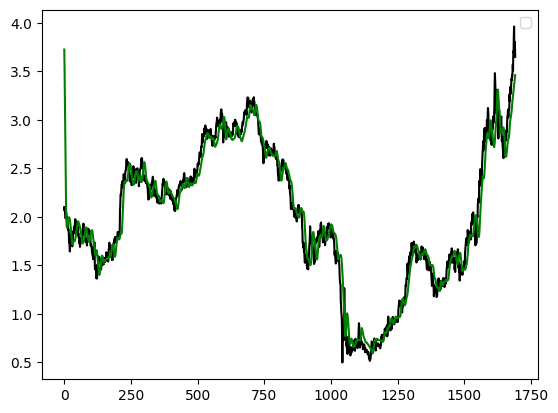

In [29]:


#PLOT

plt.plot(actual_prices, color='black')
plt.plot(predicted_prices, color='green')

plt.legend()
plt.show()
    

In [34]:
real_data = [model_inputs[len(model_inputs)]]

[3.461978]
